# First tries Deepfocus

In [2]:
%load_ext autoreload
%autoreload 2
# %load_ext tensorboard

import utils.model_utils as mut
import torch 
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
# from torch.utils.tensorboard import SummaryWriter
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os 
# import wandb
from tqdm import tqdm
from astropy.io import fits
from skimage import measure


import myUtils
from models.blobsfinder import BlobsFinder
from models.blobsfinder2 import BlobsFinder2
from models.blobsfinder3 import BlobsFinder3

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# As usual: loading the data

In [3]:
data_path = '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync'
keys = np.load(os.path.join(data_path, "Sources_detection/sky_keys.npy"))
indices_train = np.load(os.path.join(data_path, "Sources_detection/seed_0/train_idx.npy"))
indices_validation = np.load(os.path.join(data_path, "Sources_detection/seed_0/validation_idx.npy"))
indices_test = np.load(os.path.join(data_path, "Sources_detection/seed_0/test_idx.npy"))

print("Numbber of keys: ", len(keys))
print("Lenght train set: ", len(indices_train))
print("Lenght validation set: ", len(indices_validation))
print("Lenght test set: ", len(indices_test))

Numbber of keys:  9164
Lenght train set:  7331
Lenght validation set:  917
Lenght test set:  916


In [4]:
# List of images paths regarding the train, validation and test set
train_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_train]
validation_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_validation]
test_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_test]

print("Lenght train set: ", len(train_images_path))
print("Lenght validation set: ", len(validation_images_path))
print("Lenght test set: ", len(test_images_path))

Lenght train set:  7331
Lenght validation set:  917
Lenght test set:  916


In [5]:
# List of images paths regarding the train, validation and test set
train_noisy_images_path = [os.path.join(data_path, 'clean_noisy', "clean_noisy_gaussians_" + keys[ind] + ".fits") for ind in indices_train]
validation_noisy_images_path = [os.path.join(data_path, 'clean_noisy', "clean_noisy_gaussians_" + keys[ind] + ".fits") for ind in indices_validation]
test_noisy_images_path = [os.path.join(data_path, 'clean_noisy', "clean_noisy_gaussians_" + keys[ind] + ".fits") for ind in indices_test]

print("Lenght train set: ", len(train_noisy_images_path))
print("Lenght validation set: ", len(validation_noisy_images_path))
print("Lenght test set: ", len(test_noisy_images_path))

Lenght train set:  7331
Lenght validation set:  917
Lenght test set:  916


In [6]:
train_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_train, keys)
validation_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_validation, keys)
test_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_test, keys)
print("Lenght train set: ", len(train_RealDetection))
print("Lenght validation set: ", len(validation_RealDetection))
print("Lenght test set: ", len(test_RealDetection))

# compute the pixels index of ground truth positions
train_RealDetection_px = [myUtils.RaDec2pixels(train_RealDetection[ind], fits.getheader(train_images_path[ind])) for ind in tqdm(range(len(train_RealDetection)))]
validation_RealDetection_px = [myUtils.RaDec2pixels(validation_RealDetection[ind], fits.getheader(validation_images_path[ind])) for ind in tqdm(range(len(validation_RealDetection)))]
test_RealDetection_px = [myUtils.RaDec2pixels(test_RealDetection[ind], fits.getheader(test_images_path[ind])) for ind in tqdm(range(len(test_RealDetection)))]

print()
print(torch.tensor(test_RealDetection_px[0]).shape)
print(torch.tensor(test_RealDetection_px[1]).shape)
print(torch.tensor(test_RealDetection_px[2]).shape)

Lenght train set:  7331
Lenght validation set:  917
Lenght test set:  916


100%|██████████| 916/916 [00:04<00:00, 228.94it/s]


torch.Size([2, 2])
torch.Size([2, 3])
torch.Size([2, 5])


## Creatiung the training input:
An input of our nn is simply the image contained in the fits file

100%|██████████| 916/916 [00:03<00:00, 256.46it/s]


shape train input:  torch.Size([7331, 512, 512])
shape validation input:  torch.Size([917, 512, 512])
shape test input:  torch.Size([916, 512, 512])


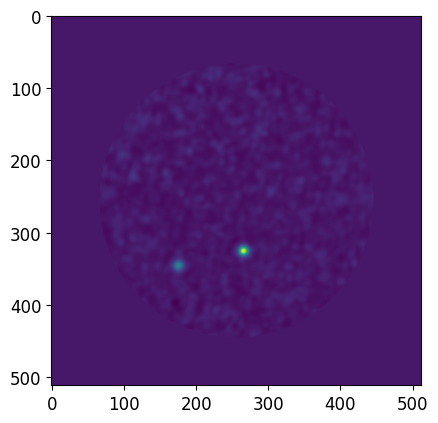

In [7]:
# open fits files from train_images_path and store them into a tensor train_input
train_input = [fits.getdata(train_images_path[ind])[0,0] for ind in tqdm(range(len(train_images_path)))]
train_input = torch.nan_to_num(torch.tensor(np.array(train_input)), nan=0)

# open fits files from validation_images_path and store them into a tensor validation_input
validation_input = [fits.getdata(validation_images_path[ind])[0,0] for ind in tqdm(range(len(validation_images_path)))]
validation_input = torch.nan_to_num(torch.tensor(np.array(validation_input)), nan=0)

# open fits files from test_images_path and store them into a tensor test_input
test_input = [fits.getdata(test_images_path[ind])[0,0] for ind in tqdm(range(len(test_images_path)))]
test_input = torch.nan_to_num(torch.tensor(np.array(test_input)), nan=0)

print("shape train input: ", train_input.shape)
print("shape validation input: ", validation_input.shape)
print("shape test input: ", test_input.shape)
plt.figure()
plt.imshow(train_input[0])
plt.show()

100%|██████████| 916/916 [00:04<00:00, 185.39it/s]


shape train input:  torch.Size([7331, 512, 512])
shape validation input:  torch.Size([917, 512, 512])
shape test input:  torch.Size([916, 512, 512])


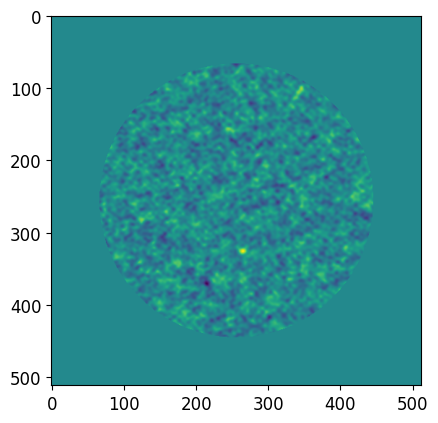

In [8]:
# open fits files from train_images_path and store them into a tensor train_input
train_noisy_input = [fits.getdata(train_noisy_images_path[ind])[0,0] for ind in tqdm(range(len(train_noisy_images_path)))]
train_noisy_input = torch.nan_to_num(torch.tensor(np.array(train_noisy_input)), nan=0)

# open fits files from validation_images_path and store them into a tensor validation_input
validation_noisy_input = [fits.getdata(validation_noisy_images_path[ind])[0,0] for ind in tqdm(range(len(validation_noisy_images_path)))]
validation_noisy_input = torch.nan_to_num(torch.tensor(np.array(validation_noisy_input)), nan=0)

# open fits files from test_images_path and store them into a tensor test_input
test_noisy_input = [fits.getdata(test_noisy_images_path[ind])[0,0] for ind in tqdm(range(len(test_noisy_images_path)))]
test_noisy_input = torch.nan_to_num(torch.tensor(np.array(test_noisy_input)), nan=0)

print("shape train input: ", train_noisy_input.shape)
print("shape validation input: ", validation_noisy_input.shape)
print("shape test input: ", test_noisy_input.shape)
plt.figure()
plt.imshow(train_noisy_input[0])
plt.show()

## Creating the target dataset
The target dataset is a zero image with 1 where there is a source. To create this tensor we use the list of real position of the source and set the pixels at this location to 1.

---- Important -----
We won't use my version bbecause I used only 1 pixel and so the size, and the shape of the source was forgotten and it was really hard to obtain good results. That's why I had to request the real binary maps (see below)

In [9]:
# torch.tensor(test_RealDetection_px[1]).shape

In [10]:
# test_RealDetection_px[1]

In [11]:
# train_target = torch.zeros(train_input.shape)
# for ind in tqdm(range(len(train_RealDetection_px))):
#     train_target[ind, train_RealDetection_px[ind][0,:], train_RealDetection_px[ind][1,:]] = 1

### Using the binary map given by olga



In [12]:
binaryMaps = np.load(os.path.join(data_path, "Sources_detection/sky_true_local_norm.npy"))
print("Binary map shape: ",binaryMaps.shape)


Binary map shape:  (9164, 512, 512)


In [13]:
train_binaryMaps = torch.tensor(binaryMaps[indices_train])
validation_binaryMaps = torch.tensor(binaryMaps[indices_validation])
test_binaryMaps = torch.tensor(binaryMaps[indices_test])

print("Lenght train binMap: ", train_binaryMaps.shape)
print("Lenght validation binMap: ", validation_binaryMaps.shape)
print("Lenght test binMap: ", test_binaryMaps.shape)

Lenght train binMap:  torch.Size([7331, 512, 512])
Lenght validation binMap:  torch.Size([917, 512, 512])
Lenght test binMap:  torch.Size([916, 512, 512])


# First NN test:
For this first test we train the model on the 916 test images just to see how it works. 

Note that I had to change some dimension size in the Deep focus source code: they had as input image of 256x256 and in our case, they are of size 512x512. So I had to change the "16" values at line 70, 93 and 96 in the blobfinder code with the value "32" which suits the desired size.


In [34]:
def ps_blob_detect(xp,loc_det='mean',jump_lim=50,area_lim=10,threshold_0=1.,return_intensity=False,verbose=False):
	"""
	 ps_blob_detect: this function detects the blobs which are candidates to be object.
	
	Arguments:
		xp (numpy array): input image.
		loc_det (string): location determination method. There are three options ('mean','peak','com').
		jump_lim (int) (default=50): this is the stop parameter. If increasing in number of object was larger than this value, threshold decreasing will be stopped.
		area_lim (int) (default=10): all of the detected blobs with area less that this value, will be ignored.
		threshold_0 (float) (default=1.0): beginning threshold to decrease.
		return_intensity (logical) (default=False): if True, the function will return average intensity of each objects as a numpy array.
		verbose (logical) (default=False): verbose of threshold finding process.
		
	--------
	Returns:
		catalog, intensity (return_intensity==True)
	"""

	xp = xp-xp.min() 
	xp = xp/xp.max()
#2: 15, 20
#3: 30,10
#4: 50, 10
	nnp = 0
	for tr in np.exp(np.linspace(np.log(threshold_0),np.log(1e-3),500)):
		blobs = measure.label(xp>tr)
		nn = np.unique(blobs).shape[0]
		if verbose:
			print('Threshold:',tr,', # of PS:',nnp)
		if nn-nnp>jump_lim:
				break
		nnp = nn
		trsh = tr

	blobs = measure.label(xp>trsh)
	xl = []
	yl = []
	al = []
	for v in np.unique(blobs)[1:]:
		filt = blobs==v


		if loc_det=='mean':
			pnt = np.round(np.mean(np.argwhere(filt),axis=0)).astype(int)
		if loc_det=='peak':
			pnt = np.array([np.where(xp==np.max(xp[filt]))[0][0],np.where(xp==np.max(xp[filt]))[1][0]]).astype(int)
		if loc_det=='com':
			pnt = cent_of_mass(xp,filt)


		if filt.sum()>area_lim:
			xl.append(pnt[1])
			yl.append(pnt[0])
			if return_intensity:
				al.append(np.mean(xp[blobs==v]))
	if return_intensity:
		return np.array([xl,yl]).T,np.array(al)
	else:
		return np.array([xl,yl]).T

In [43]:
def trainingModel(input, target, device, criterion, epochs, batch_size, hidden_channels, lr_list, weight_decay=0, modelName='modeltmp', Training = True):
    lr_index = 0
    lr = lr_list[lr_index]

    # model = BlobsFinder(hidden_channels)
    model = BlobsFinder3(hidden_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)

    if Training:
        print("Training..")
        
        model.to(device)
        input = input.to(device)
        target = target.to(device)

        lossHistory = []
        for e in range(epochs):
            # if e == 50:
            #     lr_index += 1
            #     lr = lr_list[lr_index]
            #     for g in optimizer.param_groups:
            #         g['lr'] = lr
            # if e == 100:
            #     lr_index += 1
            #     lr = lr_list[lr_index]
            #     for g in optimizer.param_groups:
            #         g['lr'] = lr

            acc_loss = 0
            for b in range(0, input.size(0), batch_size):    # using some mini batch 
                if b+batch_size <= input.shape[0]:                 # If the remaining dataset is large enough for a minibatch
                    output = model(input.narrow(0, b, batch_size).unsqueeze(1))   # unsqueeze because we need data to have shape 64x1x512x512 and not 64x512x512
                    loss = criterion(output.squeeze(1), target.narrow(0, b, batch_size))
                else:               # Else we train on the remianing inputs
                    output = model(input.narrow(0, b, input.shape[0]-b).unsqueeze(1))   # unsqueeze because we need data to have shape 64x1x512x512 and not 64x512x512
                    loss = criterion(output.squeeze(1), target.narrow(0, b, input.shape[0]-b))
                
                acc_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            lossHistory.append(acc_loss)
            print(f"\tEpoch: {e+1}, loss ={acc_loss}")

        # --- Saving the model --- #     
        torch.save({
            'epoch': epochs,
            'batch_size': batch_size,
            'hidden_channels': hidden_channels,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_history': lossHistory,
            }, './trainedModels/noisy'+modelName+'_final'+'.pt'
        )
        return model, optimizer, epochs, batch_size, hidden_channels, lossHistory
    else:
        print("Testing...")

        loadedModel = torch.load('./trainedModels/noisy/'+modelName+'_final'+'.pt', map_location=torch.device('cpu'))
        epochs, batch_size, hidden_channels = loadedModel['epoch'], loadedModel['batch_size'], loadedModel['hidden_channels']
        model.load_state_dict(loadedModel['model_state_dict'])
        optimizer.load_state_dict(loadedModel['optimizer_state_dict'])
        lossHistory = loadedModel['train_loss_history']
    
        return model, optimizer, epochs, batch_size, hidden_channels, lossHistory


In [112]:
def loadModel(epoch, hidden_channels=128, lr=0.01, weight_decay=0):
    model = BlobsFinder2(hidden_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)

    loadedModel = torch.load('./trainedModels/noisy/model_test_final_e'+str(epoch)+'.pt', map_location=torch.device('cpu'))
    epochs, batch_size, hidden_channels = loadedModel['epoch'], loadedModel['batch_size'], loadedModel['hidden_channels']
    model.load_state_dict(loadedModel['model_state_dict'])
    optimizer.load_state_dict(loadedModel['optimizer_state_dict'])
    lossHistory = loadedModel['train_loss_history']

    return model, optimizer, epochs, batch_size, hidden_channels, lossHistory


In [113]:
epochs = 200
batch_size = 64
muli_gpu = False
mode = 'train'
# learning_rate = 0.001
# learning_rate = 0.01
# weight_decay = 1e-5
weight_decay = 0
early_stopping = 'True'
patience = 20
hidden_channels = 256
warm_start=True
warm_start_iterations = 10
detection_threshold = 0.15

In [119]:
print("---"*15)
print()

lr = [0.001]
criterion = nn.L1Loss()
# model, optimizer, epochs, batch_size, hidden_channels, lossHistory = trainingModel(train_input, train_binaryMaps, device, criterion, 
                                                    # epochs, batch_size, hidden_channels, lr, modelName='model_test', Training=False)
model, optimizer, epochs, batch_size, hidden_channels, lossHistory = loadModel(399, hidden_channels=hidden_channels)

# print()
# model.eval()
print("batch size: ", batch_size)
print("hidden channels: ", hidden_channels)
print("epochs: ", epochs)
print("Validation..")

with torch.no_grad():
    # pred = model(test_input.unsqueeze(1))
    # print("Testing loss: ", criterion(pred.squeeze(1), test_binaryMaps).item())
    # pred = model(validation_input.unsqueeze(1))
    # print("Validation loss: ", criterion(pred.squeeze(1), validation_binaryMaps).item())
    # print()
    tmp_input = test_noisy_input
    tmp_target = test_binaryMaps

    pred = torch.empty(tmp_input.shape).unsqueeze(1)
    print(pred.shape)
    acc_loss = 0
    for i in tqdm(range(len(tmp_input))):
        pred[i] = model(tmp_input[i].unsqueeze(0).unsqueeze(0))
        acc_loss += criterion(pred[i].squeeze(1), tmp_target[i]).item()
    print("Validation loss: ", acc_loss/len(tmp_target))



---------------------------------------------

batch size:  64
hidden channels:  256
epochs:  400
Validation..
torch.Size([916, 1, 512, 512])


  0%|          | 0/916 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([512, 512])) that is different to the input size (torch.Size([1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 916/916 [01:17<00:00, 11.86it/s]

Validation loss:  0.0004659931211838195


Text(0.5, 1.0, 'prediction')

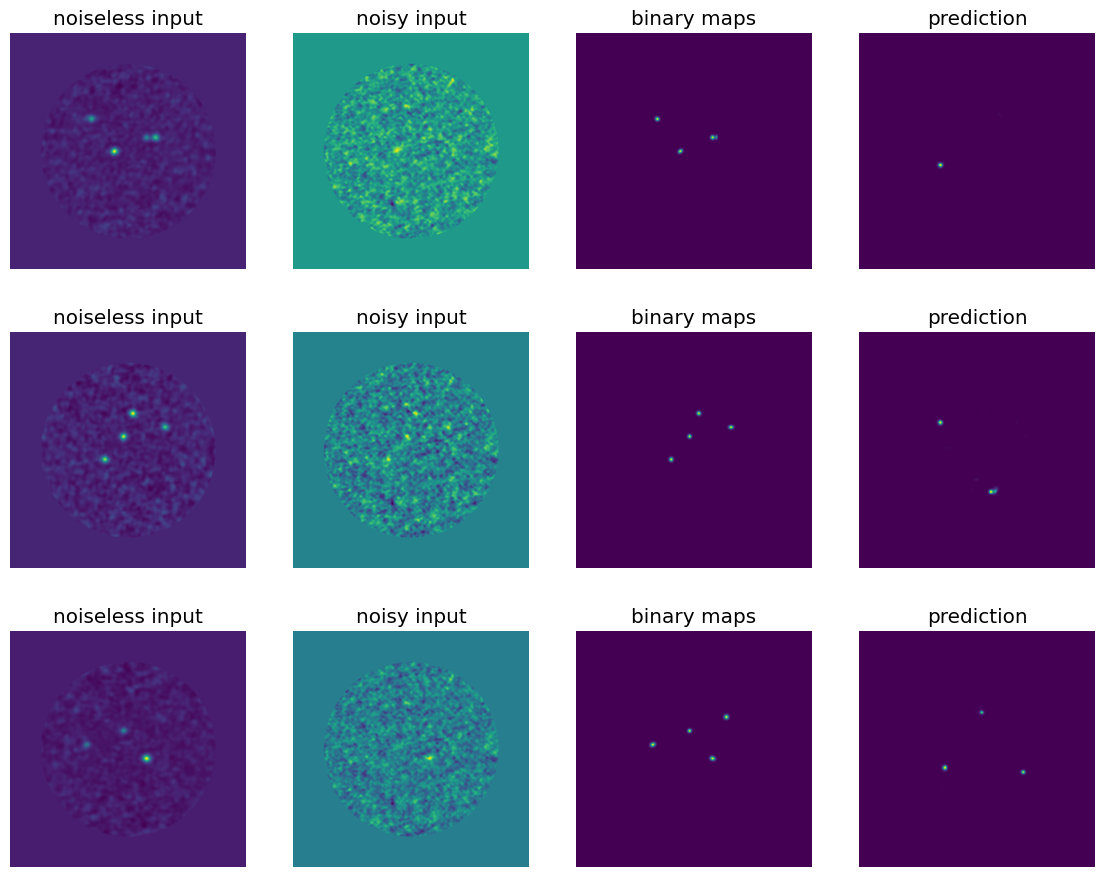

In [120]:
i=6
plt.figure(figsize=(14,11))
plt.subplot(3,4,1)
plt.imshow(validation_input[i])
plt.axis('off')
plt.title("noiseless input")
plt.subplot(3,4,2)
plt.imshow(validation_noisy_input[i])
plt.axis('off')
plt.title("noisy input")
plt.subplot(3,4,3)
plt.imshow(validation_binaryMaps[i])
plt.axis('off')
plt.title("binary maps")
plt.subplot(3,4,4)
plt.imshow(pred[i,0])
plt.axis('off')
plt.title("prediction")
plt.subplot(3,4,5)
plt.imshow(validation_input[i+1])
plt.axis('off')
plt.title("noiseless input")
plt.subplot(3,4,6)
plt.imshow(validation_noisy_input[i+1])
plt.axis('off')
plt.title("noisy input")
plt.subplot(3,4,7)
plt.imshow(validation_binaryMaps[i+1])
plt.axis('off')
plt.title("binary maps")
plt.subplot(3,4,8)
plt.imshow(pred[i+1,0])
plt.axis('off')
plt.title("prediction")
plt.subplot(3,4,9)
plt.imshow(validation_input[i+2])
plt.axis('off')
plt.title("noiseless input")
plt.subplot(3,4,10)
plt.imshow(validation_noisy_input[i+2])
plt.axis('off')
plt.title("noisy input")
plt.subplot(3,4,11)
plt.imshow(validation_binaryMaps[i+2])
plt.axis('off')
plt.title("binary maps")
plt.subplot(3,4,12)
plt.imshow(pred[i+2,0])
plt.axis('off')
plt.title("prediction")


In [121]:
detected_sources = [ps_blob_detect(pred[i,0],loc_det='mean',jump_lim=1,area_lim=170) for i in tqdm(range(len(pred)))]

100%|██████████| 916/916 [16:30<00:00,  1.08s/it]


In [122]:
# Compute the TP, FP and FN for the whole test set
resAllComparison = myUtils.compareRealAndDetectedSources_pixels(detected_sources, test_RealDetection_px)
print("Result (TP, FP, FN): ", resAllComparison)

Result (TP, FP, FN):  [1406  252 1430]


In [123]:
purityAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[1])
CompletnessAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[2])
print("Purity: ", purityAll)
print("Completness: ", CompletnessAll)

Purity:  0.8480096501809409
Completness:  0.49576868829337095


Text(0.5, 1.0, 'Binary Map')

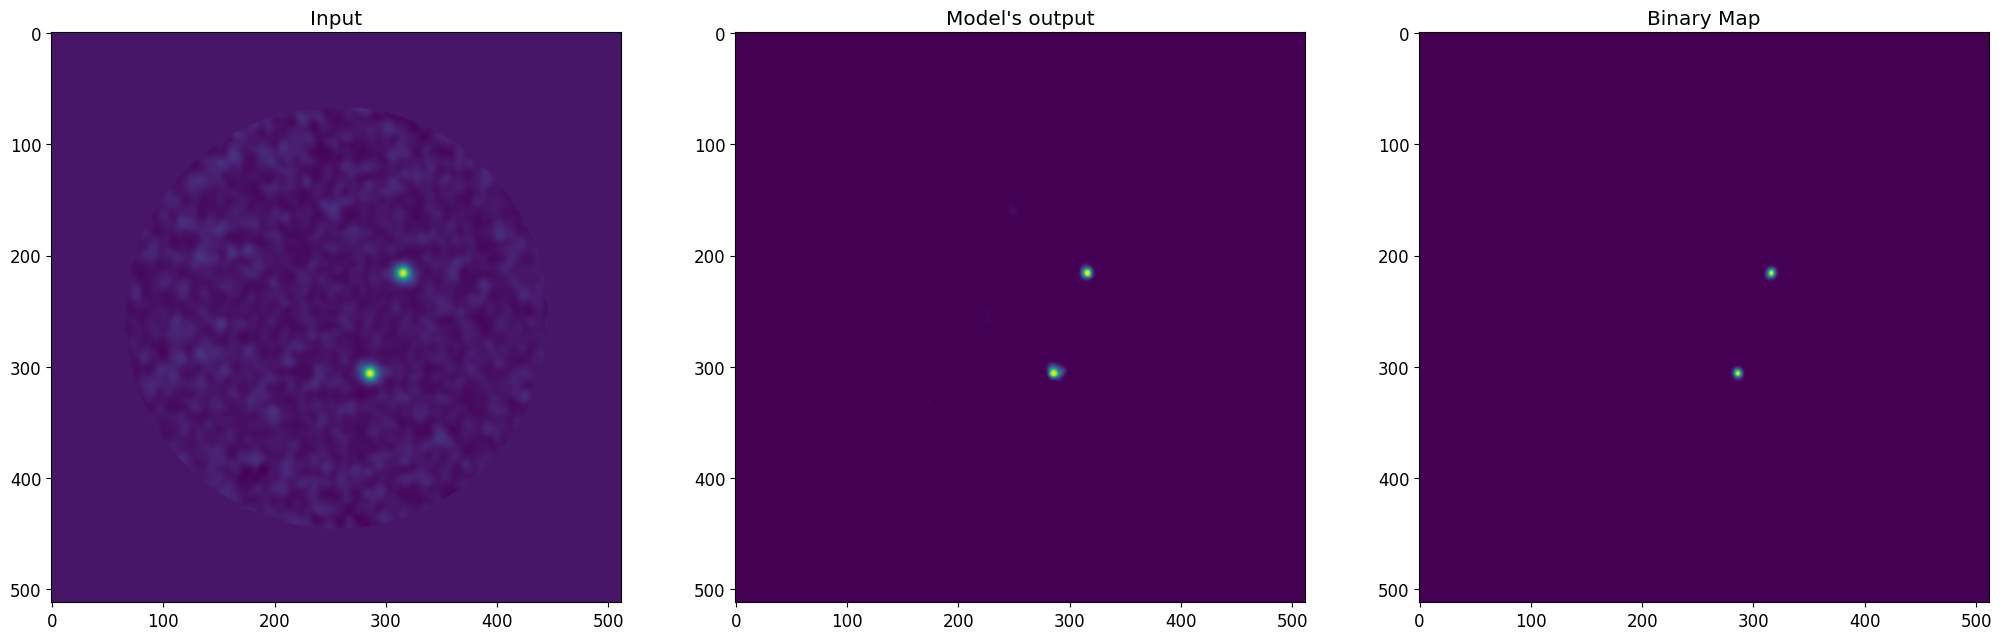

In [77]:
ind_tmp = 5
plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(tmp_input[ind_tmp])
plt.title("Input")
plt.subplot(1,3,2)
plt.imshow(pred[ind_tmp,0])
plt.title("Model's output")
plt.subplot(1,3,3)
plt.imshow(tmp_target[ind_tmp])
plt.title("Binary Map")


# without noiseless data


In [26]:
print("---"*15)
print()

lr = [0.001]
criterion = nn.L1Loss()
# model, optimizer, epochs, batch_size, hidden_channels, lossHistory = trainingModel(train_input, train_binaryMaps, device, criterion, 
                                                    # epochs, batch_size, hidden_channels, lr, modelName='model_test', Training=False)
model, optimizer, epochs, batch_size, hidden_channels, lossHistory = loadModel(299, hidden_channels=hidden_channels)

# print()
# model.eval()
print("batch size: ", batch_size)
print("hidden channels: ", hidden_channels)
print("epochs: ", epochs)
print("Validation..")

with torch.no_grad():
    # pred = model(test_input.unsqueeze(1))
    # print("Testing loss: ", criterion(pred.squeeze(1), test_binaryMaps).item())
    # pred = model(validation_input.unsqueeze(1))
    # print("Validation loss: ", criterion(pred.squeeze(1), validation_binaryMaps).item())
    # print()
    pred = torch.empty(validation_binaryMaps.shape).unsqueeze(1)
    print(pred.shape)
    acc_loss = 0
    for i in tqdm(range(len(validation_binaryMaps))):
        pred[i] = model(validation_input[i].unsqueeze(0).unsqueeze(0))
        acc_loss += criterion(pred[i].squeeze(1), validation_binaryMaps[i]).item()
    print("Validation loss: ", acc_loss/len(validation_binaryMaps))



---------------------------------------------

batch size:  64
hidden channels:  256
epochs:  300
Validation..
torch.Size([917, 1, 512, 512])


100%|██████████| 917/917 [01:14<00:00, 12.23it/s]

Validation loss:  0.0003967234029516125


Text(0.5, 1.0, 'prediction')

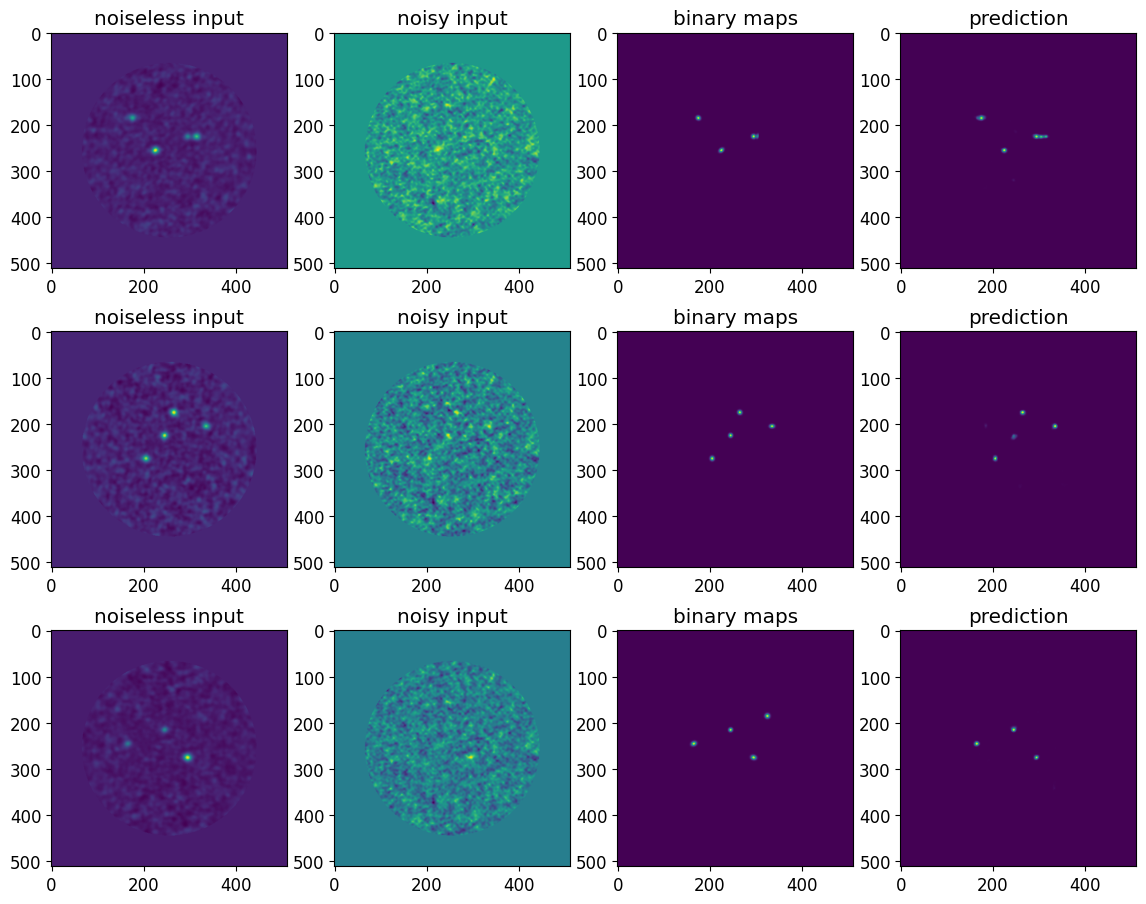

In [27]:
i=6
plt.figure(figsize=(14,11))
plt.subplot(3,4,1)
plt.imshow(validation_input[i])
plt.title("noiseless input")
plt.subplot(3,4,2)
plt.imshow(validation_noisy_input[i])
plt.title("noisy input")
plt.subplot(3,4,3)
plt.imshow(validation_binaryMaps[i])
plt.title("binary maps")
plt.subplot(3,4,4)
plt.imshow(pred[i,0])
plt.title("prediction")
plt.subplot(3,4,5)
plt.imshow(validation_input[i+1])
plt.title("noiseless input")
plt.subplot(3,4,6)
plt.imshow(validation_noisy_input[i+1])
plt.title("noisy input")
plt.subplot(3,4,7)
plt.imshow(validation_binaryMaps[i+1])
plt.title("binary maps")
plt.subplot(3,4,8)
plt.imshow(pred[i+1,0])
plt.title("prediction")
plt.subplot(3,4,9)
plt.imshow(validation_input[i+2])
plt.title("noiseless input")
plt.subplot(3,4,10)
plt.imshow(validation_noisy_input[i+2])
plt.title("noisy input")
plt.subplot(3,4,11)
plt.imshow(validation_binaryMaps[i+2])
plt.title("binary maps")
plt.subplot(3,4,12)
plt.imshow(pred[i+2,0])
plt.title("prediction")


In [28]:
detected_sources = [ps_blob_detect(pred[i,0],loc_det='mean',jump_lim=2,area_lim=170) for i in tqdm(range(len(pred)))]

# Compute the TP, FP and FN for the whole test set
resAllComparison = myUtils.compareRealAndDetectedSources_pixels(detected_sources, validation_RealDetection_px)
print("Result (TP, FP, FN): ", resAllComparison)

purityAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[1])
CompletnessAll = resAllComparison[0] / (resAllComparison[0] + resAllComparison[2])
print("Purity: ", purityAll)
print("Completness: ", CompletnessAll)

100%|██████████| 917/917 [25:26<00:00,  1.66s/it]


Result (TP, FP, FN):  [2326  242  444]
Purity:  0.9057632398753894
Completness:  0.8397111913357401


(-0.5, 511.5, 511.5, -0.5)

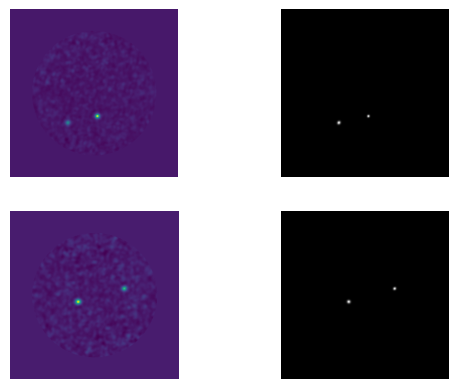

In [108]:
plt.figure()
# plot the 2 input images in column and the 2 corresponding binary map in oclumn
plt.subplot(2,2,1)
plt.imshow(train_input[0])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(train_binaryMaps[0], cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(train_input[1])
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(train_binaryMaps[1], cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

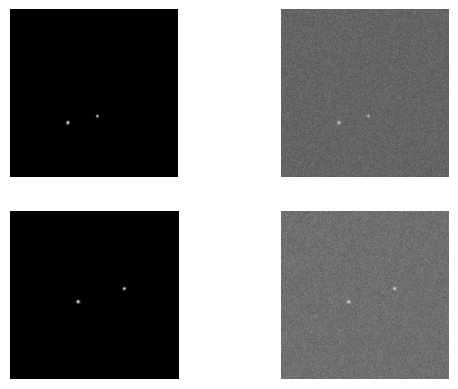

In [111]:
plt.figure()
# plot the 2 input images in column and the 2 corresponding binary map in oclumn
plt.subplot(2,2,1)
plt.imshow(train_binaryMaps[0], cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(train_binaryMaps[0]+ torch.normal(torch.zeros(train_binaryMaps[0].shape), torch.ones(train_binaryMaps[0].shape)*0.2)
, cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(train_binaryMaps[1], cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(train_binaryMaps[1]+ torch.normal(torch.zeros(train_binaryMaps[0].shape), torch.ones(train_binaryMaps[0].shape)*0.2)
, cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

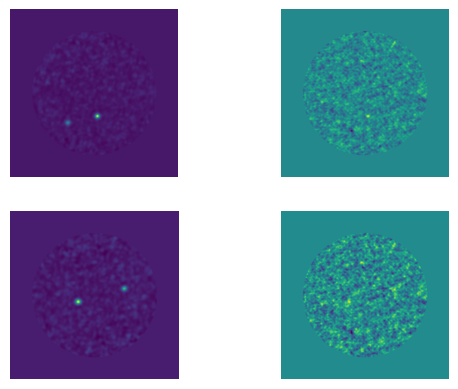

In [125]:
plt.figure()
# plot the 2 input images in column and the 2 corresponding binary map in oclumn
plt.subplot(2,2,1)
plt.imshow(train_input[0])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(train_noisy_input[0])
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(train_input[1])
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(train_noisy_input[1])
plt.axis('off')